<a href="https://colab.research.google.com/github/liquidx/ml/blob/main/MobileDiffuser_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MobileDiffuser

A model to generate a generative model with diffusion.

## Source
- https://keras.io/examples/generative/ddim/

## Dependencies

In [1]:
%%capture
!pip -q install pillow rich neptune-client wandb tensorflow_addons datasets transformers

In [2]:
import math
import pathlib
import pickle 
import time
import math
import json
import os

import numpy as np
import PIL
import PIL.Image

from IPython import display
import matplotlib.pyplot as plt
from rich import inspect

# Hugging Face
from datasets import Dataset, load_dataset, Image, Features, Value
from transformers import AutoTokenizer, DataCollatorWithPadding

# Tf/Keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from keras import layers


In [13]:
HAS_COLAB = False
try:
  import google.colab
  google.colab.drive.mount('/content/drive')

  HAS_COLAB = True
except ImportError:
  pass


Mounted at /content/drive


In [14]:
NEPTUNE_CREDENTIALS_PATH = os.path.join('/content/drive/MyDrive/ML', "neptune.txt")
NEPTUNE_CREDENTIALS = None
if os.path.exists(NEPTUNE_CREDENTIALS_PATH):
  try:
    import neptune.new as neptune
    with open(NEPTUNE_CREDENTIALS_PATH, 'r') as f:
      NEPTUNE_CREDENTIALS = f.read().strip()
  except ImportError:
    pass # silent fail
else:
  neptune = None

## GPUs

In [15]:
# Bringing in tensorflow
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
gpus    

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
!nvidia-smi

Mon Sep  5 09:13:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    34W / 250W |    391MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Config

In [17]:
class Params:
  # data
  dataset_repetitions = 5
  num_epochs = 50  # train for at least 50 epochs for good results
  image_size = 128
  # KID = Kernel Inception Distance, see related section
  kid_image_size = 75
  kid_diffusion_steps = 5
  plot_diffusion_steps = 20

  # sampling
  min_signal_rate = 0.02
  max_signal_rate = 0.95

  # architecture
  embedding_dims = 32
  embedding_max_frequency = 1000.0
  widths = [32, 64, 96, 128]
  block_depth = 2

  # optimization
  batch_size = 32
  ema = 0.999
  learning_rate = 1e-3
  weight_decay = 1e-4

  # preview
  preview_seed = 1234
  version = '1.0'
  checkpoints_dir = '/content/drive/MyDrive/ML/mobilediffuser/checkpoints'
  samples_dir = '/content/drive/MyDrive/ML/mobilediffuser/samples'

PARAMS = Params()

if not HAS_COLAB:
  PARAMS.checkpoints_dir = '/content/training-checkpoints'
  PARAMS.samples_dir = '/content/training-samples'



## Load Data

In [18]:
# Unpack data from Drive
%%capture
!unzip -o -d /content /content/drive/MyDrive/ML/datasets/ios-sl/screenshots-media.zip 
!cp /content/drive/MyDrive/ML/datasets/ios-sl/screenshots-index.json /content/screenshots-index.json


In [19]:

screenshot_images_root = '/content/screenshots/full'
screenshot_index_path = '/content/screenshots-index.json'


In [20]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


Image Shape Tensor("args_0:0", shape=(), dtype=string) (128, 128, 3)
<PrefetchDataset element_spec=TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32, name=None)>


Shape: (32, 128, 128, 3)


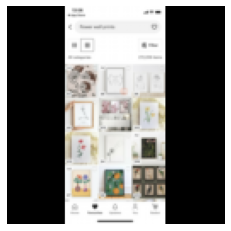

In [21]:
screenshot_index_path = '/content/screenshots-index.json'
def load_index():
  i = 0
  with open(screenshot_index_path, 'r') as f:
    index = json.load(f)
    for record in index['data']:
      path = os.path.join(screenshot_images_root, record['image'])
      if path:
        yield (path, record['title'])
        i += 1

def load_image(path, size=64):
  image = tf.io.read_file(path)
  image = tf.io.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  image = tf.image.resize_with_pad(image, size, size, antialias=True)
  #image = tf.clip_by_value(image / 255.0, 0.0, 1.0)

  # Force shape to be 64, 64, 3 even if the jpg fails to load.
  # This happens when initializing and we are passed invalid path data.
  image.set_shape([size, size, 3])

  print('Image Shape', path, image.shape)
  return image

def tokenize_title(title):
  return tokenizer(title)


def process_record(path, title, params=None):
  image = load_image(path, size=params.image_size)
  return image, title

  # tokens = tokenize_title(title)
  # return index, image, tokens['input_ids'], tokens['token_type_ids'], tokens['attention_mask']

def prepare_ds(ds, params):
    return (ds
      .cache()
      .repeat(params.dataset_repetitions)
      .shuffle(10 * params.batch_size)
      .batch(params.batch_size, drop_remainder=True)
      .prefetch(buffer_size=tf.data.AUTOTUNE)
      )
    
def split_ds(ds):
  # Split into training and test
  count = ds.cardinality()
  val_size = int(count.numpy() * 0.2)
  train_ds = ds.skip(val_size)
  val_ds = ds.take(val_size)
  return train_ds, val_ds

def load_data_from_fs(params):

  def _load_image(path):
    return load_image(path, size=params.image_size)

  main_ds = tf.data.Dataset.list_files(screenshot_images_root + '/*.jpg')
  print(main_ds.as_numpy_iterator().next())
  main_ds = main_ds.map(_load_image, num_parallel_calls=tf.data.AUTOTUNE)
  train_ds, val_ds = split_ds(main_ds)

  return prepare_ds(train_ds, params), prepare_ds(val_ds, params)


def load_data_from_json(params):
  main_ds = tf.data.Dataset.from_generator(
      load_index, 
      output_signature=(
          tf.TensorSpec(shape=(), dtype=tf.string),
          tf.TensorSpec(shape=(), dtype=tf.string)
      )
      )

  def _process_record(path, title):
    return process_record(path, title, params)

  def _drop_index_title(image, title):
    return image

  main_ds = main_ds.map(_process_record).map(_drop_index_title)
  #main_ds = dsmain_ds.map(_process_record)
  

  # Split into training and test
  train_ds, val_ds = split_ds(main_ds)

  #return train_ds, test_ds
  return prepare_ds(train_ds, params), prepare_ds(val_ds, params)
  
ds = None
train_ds, test_ds = load_data_from_json(PARAMS)

# Debugging
print(train_ds)
record = train_ds.take(1).as_numpy_iterator().next()
print("Shape:", record.shape)


def show(image, label=""):
  plt.figure()
  plt.imshow(image)
  #plt.title(label.numpy().decode('utf-8'))
  #plt.title(label.decode('utf-8'))
  plt.axis('off')

show(record[0])


## Model

This is the loss function using KID. This uses ImageNet to do a recognition on the image and then compare the identified items.


In [22]:
class KID(keras.metrics.Metric):
    def __init__(self, params, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        image_size = params.image_size
        kid_image_size = params.kid_image_size
        
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(
            kernel_generated * (1.0 - tf.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()

### U-Net


In [23]:
def sinusoidal_embedding(x, params):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(params.embedding_max_frequency),
            params.embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings


def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply


def get_network(params):
    image_size = params.image_size
    widths = params.widths
    block_depth = params.block_depth
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))

    def _sinusoidal_embedding(x):
      return sinusoidal_embedding(x, params)
    e = layers.Lambda(_sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")

In [24]:
class DiffusionModel(keras.Model):
    def __init__(self,  params):
        super().__init__()

        self.params = params
        self.normalizer = layers.Normalization()
        self.network = get_network(params)
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        self.kid = KID(self.params, name="kid")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(self.params.max_signal_rate)
        end_angle = tf.acos(self.params.min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps, seed=None):
        image_size = self.params.image_size
        # noise -> images -> denormalized images
        tf.random.set_seed(5)
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 3), seed=seed)
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        batch_size = self.params.batch_size
        image_size = self.params.image_size
        ema = self.params.ema
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, images):
        batch_size = self.params.batch_size
        image_size = self.params.image_size
        kid_diffusion_steps = self.params.kid_diffusion_steps

        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        # measure KID between real and generated images
        # this is computationally demanding, kid_diffusion_steps has to be small
        images = self.denormalize(images)
        generated_images = self.generate(
            num_images=batch_size, diffusion_steps=kid_diffusion_steps
        )
        self.kid.update_state(images, generated_images)

        return {m.name: m.result() for m in self.metrics}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6):
        plot_diffusion_steps = self.params.plot_diffusion_steps

        # plot random generated images for visual evaluation of generation quality
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
            seed=self.params.preview_seed
        )

        plt.figure(figsize=(num_cols * 4.0, num_rows * 4.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.tight_layout()

        # save generated images
        if self.params.samples_dir:
          path = os.path.join(self.params.samples_dir, 
                              self.params.version, 
                              'image_at_epoch_{:04d}.png'.format(epoch))
          plt.savefig(path)

        plt.show()
        plt.close()



## Training

In [ ]:
def train(params, train_dataset, val_dataset):
  learning_rate = params.learning_rate
  weight_decay = params.weight_decay
  num_epochs = params.num_epochs

  # create and compile the model
  model = DiffusionModel(params)
  # below tensorflow 2.9:
  # pip install tensorflow_addons
  # import tensorflow_addons as tfa
  # optimizer=tfa.optimizers.AdamW
  model.compile(
      optimizer=tfa.optimizers.AdamW(
          learning_rate=learning_rate, weight_decay=weight_decay
      ),
      loss=keras.losses.mean_absolute_error,
  )
  # pixelwise mean absolute error is used as loss


  checkpoints_dir = os.path.join(params.checkpoints_dir, params.version, 'cp')

  # load checkpoint if it exists
  latest = tf.train.latest_checkpoint(checkpoints_dir)
  if latest:
    model.load_weights(latest)

  # save the best model based on the validation KID metric
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoints_dir,
      save_weights_only=True,
      monitor="kid",
      mode="min",
      save_freq='epoch',
      verbose=1
      #save_best_only=True,
  )

  # calculate mean and variance of training dataset for normalization
  model.normalizer.adapt(train_dataset)

  # run training and plot generated images periodically
  model.fit(
      train_dataset,
      epochs=num_epochs,
      validation_data=val_dataset,
      callbacks=[
          keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
          checkpoint_callback,
      ],
  )
  return model

PARAMS.version = 'v1.3'
model = train(PARAMS, train_ds, test_ds)  

## Debugging

In [32]:
latest = tf.train.latest_checkpoint('/content/drive/MyDrive/ML/mobilediffuser/checkpoints/v1.3')
model.load_weights(latest)


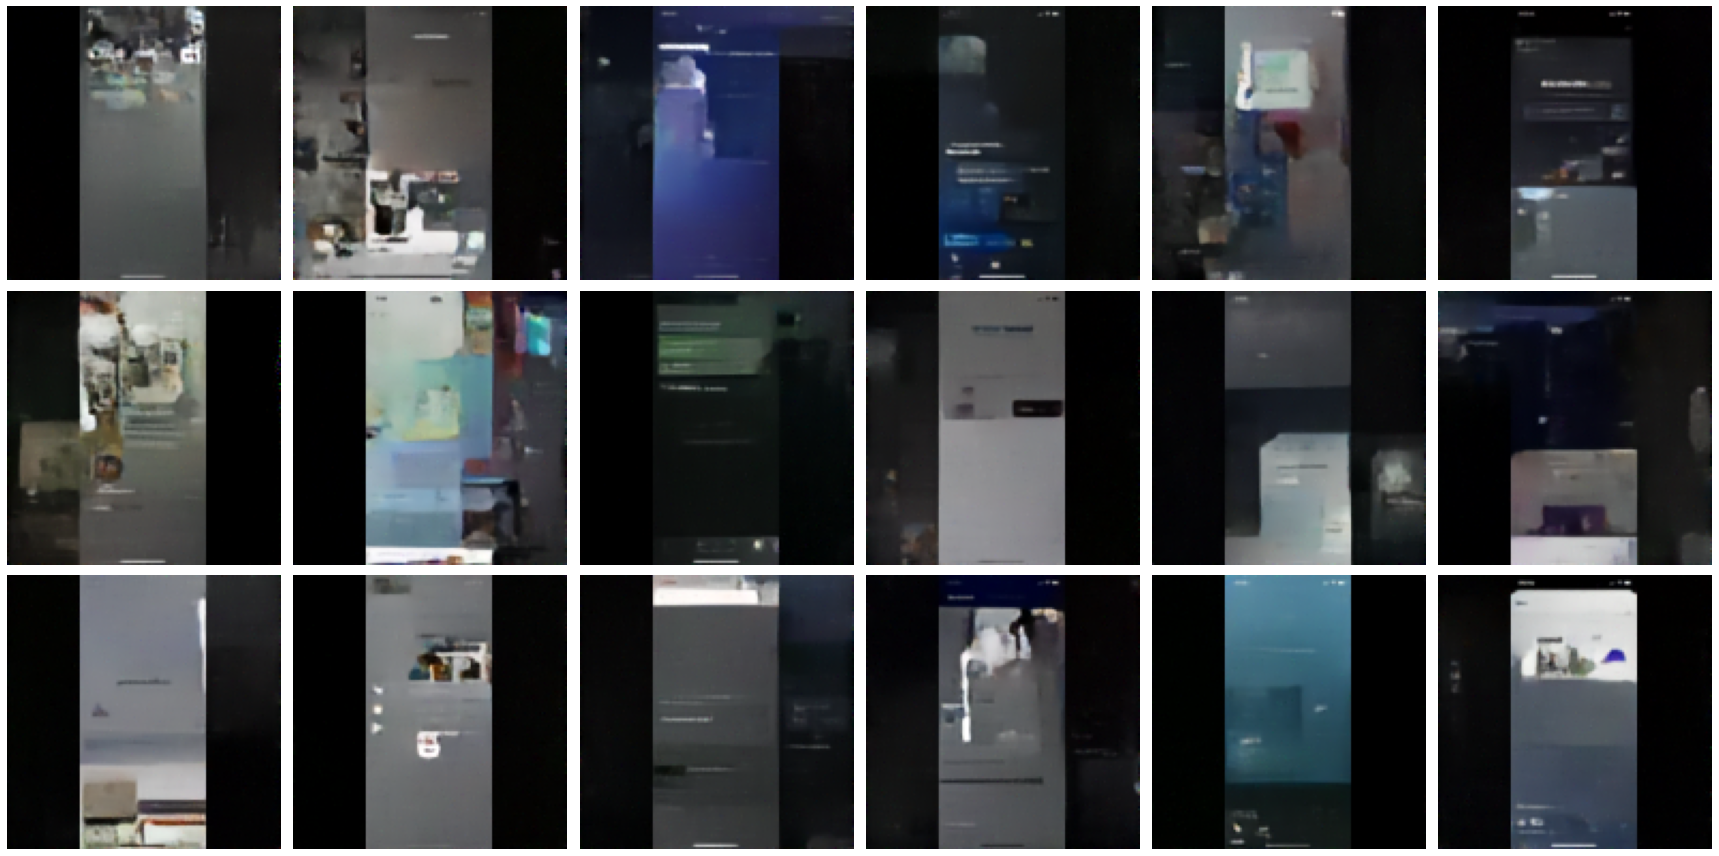

In [34]:
def plot_images(model, params, num_rows=3, num_cols=6):
  plot_diffusion_steps = params.plot_diffusion_steps

  # plot random generated images for visual evaluation of generation quality
  generated_images = model.generate(
      num_images=num_rows * num_cols,
      diffusion_steps=plot_diffusion_steps
  )

  plt.figure(figsize=(num_cols * 4.0, num_rows * 4.0))
  for row in range(num_rows):
      for col in range(num_cols):
          index = row * num_cols + col
          plt.subplot(num_rows, num_cols, index + 1)
          plt.imshow(generated_images[index])
          plt.axis("off")
  plt.tight_layout()

  # # save generated images
  # if self.params.samples_dir:
  #   path = os.path.join(self.params.samples_dir, 
  #                       self.params.version, 
  #                       'image_at_epoch_{:04d}.png'.format(epoch))
  #   plt.savefig(path)

  plt.show()
  plt.close()

plot_images(model, PARAMS)

In [ ]:
def show(image, label):
  plt.figure()
  plt.imshow(image)
  #plt.title(label.numpy().decode('utf-8'))
  #plt.title(label.decode('utf-8'))
  plt.axis('off')

record = train_ds.take(1).as_numpy_iterator().next()
image = record[1]
print(image)
show(image, "")

## Experimental

In [ ]:
def preprocess_image(data, params):
    # center crop image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    image_size = params.image_size
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    return tf.clip_by_value(image / 255.0, 0.0, 1.0)


def prepare_dataset(split, params):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID estimation
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .repeat(dataset_repetitions)
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


def load_using_keras_dataset(dirname, params):
  """
  This will already do batching/shuffling/prefetch
  https://github.com/keras-team/keras/blob/v2.9.0/keras/utils/image_dataset.py#L29-L235
  """
  ds = image_dataset_from_directory(dirname, 
                                    labels=None,
                                    color_mode="rgb",
                                    shuffle=True,
                                    image_size=params.image_size,
                                    batch_size=params.batch_size)
  return ds.map(scale_images_to_minus_plus_one)


# load dataset
train_dataset = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]")
val_dataset = prepare_dataset("train[80%:]+validation[80%:]+test[80%:]")